<a href="https://colab.research.google.com/github/rokmc3852/study/blob/master/torch(basic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!gdown https://drive.google.com/uc?id=1ShvcyfiG0oXHWTnvSoy7UL0gcIZd_why
!unzip /content/dog_vs_cat.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: dog_vs_cat/dog/dog.5499.jpg  
  inflating: dog_vs_cat/dog/dog.55.jpg  
  inflating: dog_vs_cat/dog/dog.550.jpg  
  inflating: dog_vs_cat/dog/dog.5500.jpg  
  inflating: dog_vs_cat/dog/dog.5501.jpg  
  inflating: dog_vs_cat/dog/dog.5502.jpg  
  inflating: dog_vs_cat/dog/dog.5503.jpg  
  inflating: dog_vs_cat/dog/dog.5504.jpg  
  inflating: dog_vs_cat/dog/dog.5505.jpg  
  inflating: dog_vs_cat/dog/dog.5506.jpg  
  inflating: dog_vs_cat/dog/dog.5507.jpg  
  inflating: dog_vs_cat/dog/dog.5508.jpg  
  inflating: dog_vs_cat/dog/dog.5509.jpg  
  inflating: dog_vs_cat/dog/dog.551.jpg  
  inflating: dog_vs_cat/dog/dog.5510.jpg  
  inflating: dog_vs_cat/dog/dog.5511.jpg  
  inflating: dog_vs_cat/dog/dog.5512.jpg  
  inflating: dog_vs_cat/dog/dog.5513.jpg  
  inflating: dog_vs_cat/dog/dog.5514.jpg  
  inflating: dog_vs_cat/dog/dog.5515.jpg  
  inflating: dog_vs_cat/dog/dog.5516.jpg  
  inflating: dog_vs_cat/dog/dog.5517.jpg  
  inflating: dog_vs_ca

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import cv2
import random
from glob import glob
from datetime import datetime

%matplotlib inline
plt.style.use('seaborn')
# 필요한 라이브러리 임포트

<ipython-input-3-01b4f26648ad>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
# 항상 실행결과가 동일하게 나오게 값 설정
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
# AI 모델 학습 파라미터 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size=512
epoch=30
patience=5
lr=0.0001
input_size=28
class_num=2

print(f'device : {device}\ntorch_version : {torch.__version__}')

device : cuda
torch_version : 2.3.0+cu121


In [7]:
# 데이터 불러오기
cat_directory = '/content/dog_vs_cat/cat/'
dog_directory = '/content/dog_vs_cat/dog/'

cat_images_filepaths = glob(cat_directory + '*.jpg')
dog_images_filepaths = glob(dog_directory + '*.jpg')

images_filepaths = [*cat_images_filepaths[:5000], *dog_images_filepaths[:5000]]
random.seed(42)
random.shuffle(images_filepaths)

train_path, val_path = train_test_split(images_filepaths, test_size=0.2, random_state=42)
print(f'train data : {len(train_path)}')
print(f'val data : {len(val_path)}')

train data : 8000
val data : 2000


In [9]:
# 이미지 변환 처리(리사이징, 노멀라이즈)
check_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# 데이터 고화질 확인용 클래스 정의
class CheckDataset():
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        img = cv2.imread(self.path[idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            img = self.transform(img)

        if self.path[idx].split('/')[3] == 'cat':label = 0
        elif self.path[idx].split('/')[3] == 'dog':label = 1

        return img, label

c_train_data = CheckDataset(train_path, transform=check_transform)
c_test_data = CheckDataset(val_path, transform=check_transform)

c_train_loader = DataLoader(c_train_data, batch_size=batch_size, shuffle=True)
c_test_loader = DataLoader(c_test_data, batch_size=batch_size, shuffle=True)


<class 'torch.Tensor'> torch.Size([512, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([512])


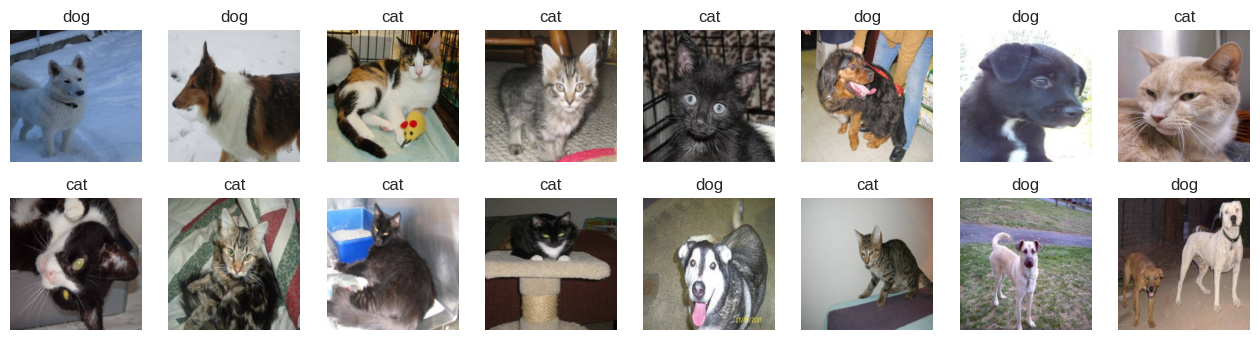

In [10]:
# 데이터셋 한 배치씩 불러오기
img, cla = next(iter(c_train_loader))

# 차원 형태 출력
print(type(img), img.shape)
print(type(cla), cla.shape)

row, col = 2, 8

k = 0

# 이미지를 출력할 켄버스 생성
fig, axes = plt.subplots(row, col, figsize=(16, 4))

# 반복문을 사용하여 이미지와 라벨 출력
for i in range(row):
    for j in range(col):
        ax = axes[i, j]
        ax.axis('off')
        ax.imshow(torch.permute(img[k], (1, 2, 0)))
        if cla[k] == 0: ax.set_title("cat")
        else: ax.set_title("dog")
        k += 1

In [12]:
# 이미지 변환 처리(리사이징, 노멀라이즈)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# 데이터셋 생성
class CustomDataset():
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        img = cv2.imread(self.path[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            img = self.transform(img)

        if self.path[idx].split('/')[3] == 'cat':label = 0
        elif self.path[idx].split('/')[3] == 'dog':label = 1

        return img, label

In [13]:
# 학습할 데이터셋 생성
train_data = CustomDataset(train_path, transform=transform)
test_data = CustomDataset(val_path, transform=transform)

# 데이터 값 확인
train_data.__getitem__(0)

(tensor([[[ 0.9686,  0.9216,  0.7804,  0.9137,  0.9686,  0.9686,  0.9686,
            0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,
            0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,
            0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.5216,  0.0510,  0.3333,  0.8745,  0.9686,  0.9686,
            0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,
            0.9686,  0.9686,  0.9529,  0.7647,  0.5137,  0.8745,  0.9686,
            0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686],
          [ 0.9451,  0.3098,  0.0824, -0.0510,  0.2627,  0.8824,  0.9686,
            0.9686,  0.9608,  0.9451,  0.9059,  0.8902,  0.9451,  0.9686,
            0.9686,  0.8588,  0.3647, -0.1216, -0.0275,  0.7725,  0.9686,
            0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686,  0.9686],
          [ 0.9059,  0.2706,  0.0118,  0.0275, -0.0667,  0.2235,  0.6627,
            0.6706,  0.5059,  0.349

In [14]:
# 배치사이즈 데이터 로더 생성
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [15]:
# CNN 인공지능 모델링
class Ai(nn.Module):
    def __init__(self):
        super(Ai, self).__init__()

        # 특징추출
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=(2, 2)),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=(2, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        # 분류기
        self.classifier = nn.Sequential(
            nn.Linear(in_features=1 * input_size * input_size, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=class_num)
        )

    # 실행
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 모델 디바이스 탑재
model=Ai().to(device)
# 모델 구조 출력
print(model)

Ai(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=2, bias=True)
  )
)


In [16]:
# 손실함수, 옵티마이저
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
t_data_len = len(train_data)
v_data_len = len(test_data)

t_t_loss, t_t_acc = [], []
t_v_loss, t_v_acc = [], []

# 모델 학습
for e in range(epoch):
    r_t_loss, r_t_acc = 0.0, 0.0
    r_v_loss, r_v_acc = 0.0, 0.0

    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        r_t_loss += loss.item() * inputs.size(0)

        _, pred = torch.max(outputs, 1)
        r_t_acc += torch.sum(pred == labels).item()

    t_t_loss.append(r_t_loss / t_data_len)
    t_t_acc.append(r_t_acc / t_data_len)


    with torch.no_grad():
        model.eval()
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            r_v_loss += loss.item() * inputs.size(0)

            _, pred = torch.max(outputs, 1)
            r_v_acc += torch.sum(pred == labels).item()

    t_v_loss.append(r_v_loss / v_data_len)
    t_v_acc.append(r_v_acc / v_data_len)

    print(
        f'{datetime.now().time().replace(microsecond=0)} -- '
        f'epoch : {e + 1}\n'
        f'train_loss : {t_t_loss[e]:.4f}\ttrain_acc : {t_t_acc[e] * 100:.2f}%\n'
        f'val_loss : {t_v_loss[e]:.4f}\tval_acc : {t_v_acc[e] * 100:.2f}%'
    )

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:05:12 -- epoch : 1
train_loss : 0.6895	train_acc : 53.71%
val_loss : 0.6895	val_acc : 51.65%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:05:29 -- epoch : 2
train_loss : 0.6783	train_acc : 59.05%
val_loss : 0.6775	val_acc : 58.95%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:05:46 -- epoch : 3
train_loss : 0.6678	train_acc : 60.36%
val_loss : 0.6625	val_acc : 61.20%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:06:02 -- epoch : 4
train_loss : 0.6566	train_acc : 61.78%
val_loss : 0.6514	val_acc : 61.55%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:06:19 -- epoch : 5
train_loss : 0.6465	train_acc : 62.79%
val_loss : 0.6422	val_acc : 62.70%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:06:36 -- epoch : 6
train_loss : 0.6384	train_acc : 64.14%
val_loss : 0.6366	val_acc : 62.95%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:06:53 -- epoch : 7
train_loss : 0.6305	train_acc : 64.78%
val_loss : 0.6308	val_acc : 63.45%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:07:09 -- epoch : 8
train_loss : 0.6211	train_acc : 66.10%
val_loss : 0.6228	val_acc : 64.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:07:26 -- epoch : 9
train_loss : 0.6123	train_acc : 66.54%
val_loss : 0.6163	val_acc : 65.65%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:07:43 -- epoch : 10
train_loss : 0.6041	train_acc : 67.64%
val_loss : 0.6075	val_acc : 66.55%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:07:59 -- epoch : 11
train_loss : 0.5946	train_acc : 68.50%
val_loss : 0.6001	val_acc : 67.95%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:08:15 -- epoch : 12
train_loss : 0.5864	train_acc : 69.42%
val_loss : 0.5932	val_acc : 68.15%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:08:33 -- epoch : 13
train_loss : 0.5790	train_acc : 70.04%
val_loss : 0.5877	val_acc : 68.95%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:08:49 -- epoch : 14
train_loss : 0.5720	train_acc : 71.14%
val_loss : 0.5833	val_acc : 68.90%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:09:06 -- epoch : 15
train_loss : 0.5657	train_acc : 71.50%
val_loss : 0.5823	val_acc : 69.25%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:09:22 -- epoch : 16
train_loss : 0.5633	train_acc : 71.49%
val_loss : 0.5794	val_acc : 68.75%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:09:39 -- epoch : 17
train_loss : 0.5552	train_acc : 71.89%
val_loss : 0.5720	val_acc : 69.60%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:09:56 -- epoch : 18
train_loss : 0.5491	train_acc : 72.20%
val_loss : 0.5670	val_acc : 70.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:10:12 -- epoch : 19
train_loss : 0.5437	train_acc : 72.82%
val_loss : 0.5660	val_acc : 69.80%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:10:29 -- epoch : 20
train_loss : 0.5382	train_acc : 73.34%
val_loss : 0.5631	val_acc : 71.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:10:46 -- epoch : 21
train_loss : 0.5328	train_acc : 73.46%
val_loss : 0.5595	val_acc : 71.15%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:11:02 -- epoch : 22
train_loss : 0.5278	train_acc : 73.67%
val_loss : 0.5578	val_acc : 71.25%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:11:19 -- epoch : 23
train_loss : 0.5247	train_acc : 74.29%
val_loss : 0.5565	val_acc : 71.70%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:11:36 -- epoch : 24
train_loss : 0.5206	train_acc : 74.52%
val_loss : 0.5533	val_acc : 72.00%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:11:52 -- epoch : 25
train_loss : 0.5127	train_acc : 75.66%
val_loss : 0.5529	val_acc : 71.80%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:12:08 -- epoch : 26
train_loss : 0.5075	train_acc : 75.52%
val_loss : 0.5543	val_acc : 71.45%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:12:26 -- epoch : 27
train_loss : 0.5061	train_acc : 75.55%
val_loss : 0.5522	val_acc : 71.45%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:12:43 -- epoch : 28
train_loss : 0.5012	train_acc : 76.01%
val_loss : 0.5517	val_acc : 71.95%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:12:59 -- epoch : 29
train_loss : 0.4947	train_acc : 76.72%
val_loss : 0.5491	val_acc : 72.75%


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05:13:16 -- epoch : 30
train_loss : 0.4899	train_acc : 76.45%
val_loss : 0.5482	val_acc : 71.40%


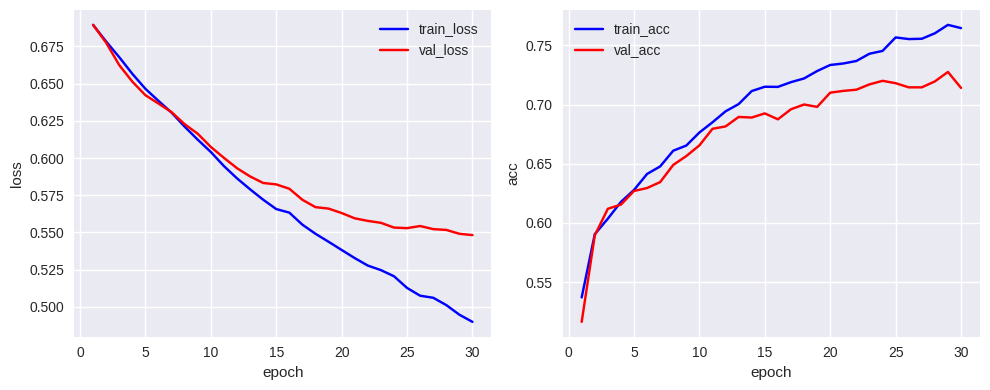

In [18]:
# 학습이 잘되었는지 로스와 엑큐러시 그래프 확인
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch + 1), t_t_loss, 'b', label='train_loss')
plt.plot(range(1, epoch + 1), t_v_loss, 'r', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epoch + 1), t_t_acc, 'b', label='train_acc')
plt.plot(range(1, epoch + 1), t_v_acc, 'r', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

plt.tight_layout()

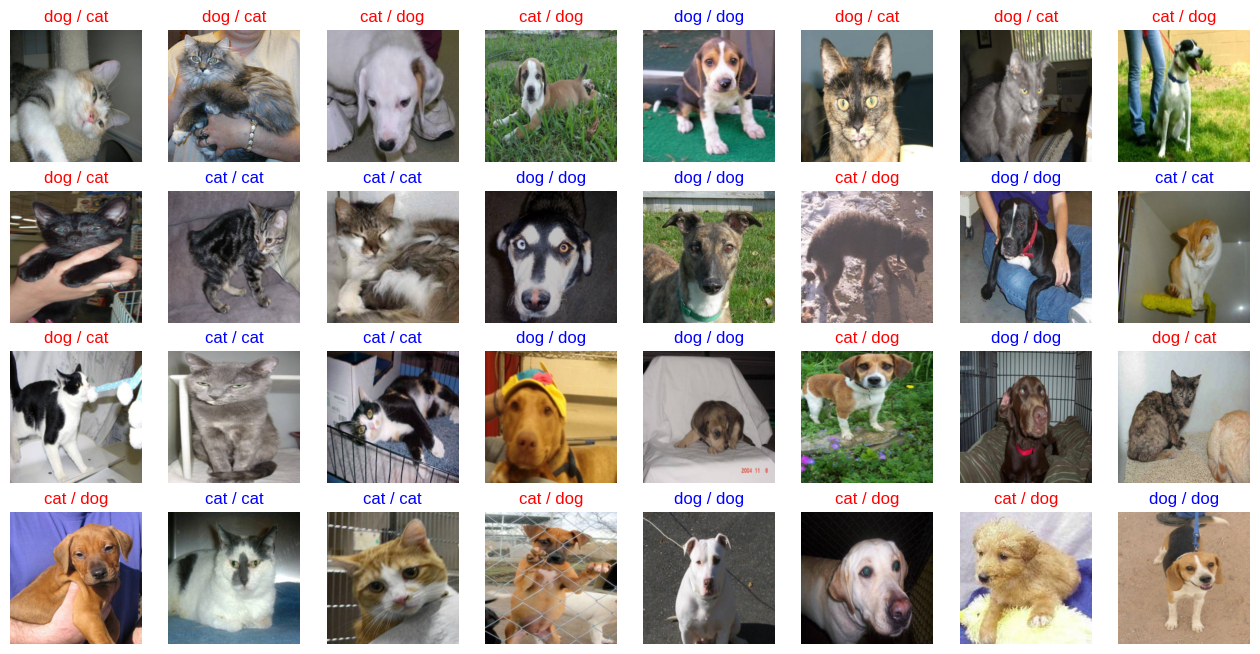

In [19]:
# 정답을 잘 맞추었는지 시각화하여 확인
c_inputs, c_labels = next(iter(c_test_loader))
inputs, labels = next(iter(test_loader))

with torch.no_grad():
    model.eval()
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    r_v_loss += loss.item() * inputs.size(0)

    _, pred = torch.max(outputs, 1)
    r_v_acc += torch.sum(pred == labels).item()


l_dic = {0:'cat', 1:'dog'}
row, col = 4, 8
k = 0
# 이미지를 출력할 켄버스 생성
fig, axes = plt.subplots(row, col, figsize=(16, 8))

# 반복문을 사용하여 이미지와 라벨 출력
for i in range(row):
    for j in range(col):
        ax = axes[i, j]
        ax.axis('off')
        ax.imshow(torch.permute(c_inputs[k], (1, 2, 0)))
        if pred[k] == c_labels[k]: ax.set_title(l_dic[int(pred[k])] + ' / ' + l_dic[int(c_labels[k])], color="b")
        else: ax.set_title(l_dic[int(pred[k])] + ' / ' + l_dic[int(c_labels[k])], color="r")
        k += 1
